### 开始

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [ ]:
path_data = 'D:/SGYL/SM_results_data/Train/data/'
for i in os.listdir(path_data):
    print(i)
    data = pd.read_csv(os.path.join(path_data,i))
    data_train,data_validate = train_test_split(data,test_size=0.3,random_state=42)
    data_validate,data_test = train_test_split(data_validate,test_size=0.3,random_state=42)
    print(i)
    print(len(data_train),len(data_validate),len(data_test))
    data_train.to_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','train_'+i),index = False)
    data_validate.to_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','validate_'+i),index = False)
    data_test.to_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','test_'+i),index = False)


In [4]:
year = 2020
data_train = pd.read_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','train_data_'+str(year)+'.csv'))
data_validate = pd.read_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','validate_data_'+str(year)+'.csv'))
data_test = pd.read_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','test_data_'+str(year)+'.csv'))

In [5]:
X_train = data_train.drop(['SM'],axis = 1)
y_train = data_train['SM'].copy()
X_validate = data_validate.drop(['SM'],axis = 1)
y_validate = data_validate['SM'].copy()
X_test = data_test.drop(['SM'],axis = 1)
y_test = data_test['SM'].copy()

In [33]:
from sklearn.preprocessing import StandardScaler

standarder = StandardScaler()
X_train = standarder.fit_transform(X_train)
X_validate = standarder.transform(X_validate)
X_test = standarder.transform(X_test)

### Model

### XGBoost

In [19]:
import xgboost as xgb

In [20]:
sk_xgb = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.7,max_depth = 15, n_estimators=2000,learning_rate = 0.01,
                          colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0)
sk_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, ...)

In [21]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
y_pred = sk_xgb.predict(X_validate)
print('rmse',np.sqrt(mean_squared_error(y_validate,y_pred)))
print('mae',mean_absolute_error(y_validate,y_pred))
print('r2',r2_score(y_validate,y_pred))

rmse 0.01723312126128644
mae 0.012250178211914773
r2 0.9618659343304164


In [22]:
#2
sorted(zip(sk_xgb.feature_importances_,list(data_test.drop('SM',axis = 1))),reverse=True)

[(0.15067607, 'Lat'),
 (0.12787566, 'Lon'),
 (0.12364552, 'SWCI'),
 (0.098695114, 'Clay'),
 (0.08334655, 'VSDI'),
 (0.057358682, 'Sand'),
 (0.05617455, 'DEM'),
 (0.054445814, 'Slope'),
 (0.053744726, 'Silt'),
 (0.043646306, 'DOY'),
 (0.03512873, 'Aspect'),
 (0.03343765, 'LST_Diff'),
 (0.024039268, 'ET'),
 (0.011124251, 'EVI'),
 (0.011012912, 'LST'),
 (0.0108425915, 'SIWSI'),
 (0.010553844, 'TWI'),
 (0.0077486243, 'NDVI'),
 (0.0065031373, 'Pre')]

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators':range(500,5000,500),
     'learning_rate': [0.1,0.2,0.01,0.05],
     'max_depth ': range(5,15,1)
    } 
]
rf_reg = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8,
                          colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0)
GS_bst = GridSearchCV(rf_reg,param_grid,scoring='neg_mean_squared_error',return_train_score=True,cv=3,n_jobs=1)
GS_bst.fit(X_train,y_train)

In [ ]:
GS_bst.best_params_

### Bayesian opt

In [27]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [28]:
def bst_cv(n,eta,md):
    model = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8,
                         n_estimators=int(n),learning_rate = eta,max_depth = int(md),
                         colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_validate)
    res = np.sqrt(mean_squared_error(y_validate,y_pred))
    return (-1.0 * res)


In [29]:
bst_bo = BayesianOptimization(
    bst_cv,
    {
        'n':(500,3000),
        'eta':(0.0001,0.1),
        'md':(5,15)
    }
)

In [30]:
bst_bo.maximize(n_iter=100)

|   iter    |  target   |    eta    |    md     |     n     |
-------------------------------------------------------------
|  1        | -0.02067  |  0.02525  |  9.875    |  1.082e+0 |
|  2        | -0.02566  |  0.03739  |  5.735    |  1.815e+0 |
|  3        | -0.06729  |  0.000732 |  7.9      |  2.2e+03  |
|  4        | -0.01697  |  0.02133  |  13.64    |  2.943e+0 |
|  5        | -0.02939  |  0.0295   |  5.844    |  814.1    |
|  6        | -0.01739  |  0.05799  |  14.03    |  2.813e+0 |
|  7        | -0.02234  |  0.06464  |  6.665    |  1.448e+0 |
|  8        | -0.01789  |  0.1      |  15.0     |  500.0    |
|  9        | -0.01791  |  0.1      |  15.0     |  1.259e+0 |
|  10       | -0.2783   |  1e-05    |  15.0     |  1.642e+0 |
|  11       | -0.023    |  0.05193  |  5.667    |  2.878e+0 |
|  12       | -0.0173   |  0.06037  |  13.25    |  1.258e+0 |
|  13       | -0.03007  |  0.009872 |  5.0      |  1.958e+0 |
|  14       | -0.01739  |  0.06007  |  14.71    |  2.617e+0 |
|  15   

In [31]:
bst_bo.max

{'target': -0.016971938776559198,
 'params': {'eta': 0.02132623206887078,
  'md': 13.64419100902513,
  'n': 2942.9044250432858}}

In [34]:
model = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8,
                         n_estimators=int(bst_bo.max['params']['n']),learning_rate = bst_bo.max['params']['eta'],
                         max_depth = int(bst_bo.max['params']['md']),colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('rmse',np.sqrt(mean_squared_error(y_test,y_pred)))
print('mae',mean_absolute_error(y_test,y_pred))
print('r2',r2_score(y_test,y_pred))

rmse 0.01728502175035403
mae 0.01208805327576452
r2 0.961580997481861


In [35]:
model.save_model('D:/SGYL/SM_results_data/model/XGBoost_2020.json')

### Loop

In [7]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import xgboost as xgb

mae = dict()
rmse = dict()
R2 = dict()
error_index = []


def bst_cv(n,eta,md):
    model = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8,
                         n_estimators=int(n),learning_rate = eta,max_depth = int(md),
                         colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_validate)
    res = np.sqrt(mean_squared_error(y_validate,y_pred))
    return (-1.0 * res)

In [9]:
for year in range(2001,2020):
    try:
        print(os.path.join('D:/SGYL/SM_results_data/Train/split/','train_data_'+str(year)+'.csv'))
        data_train = pd.read_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','train_data_'+str(year)+'.csv'))
        data_validate = pd.read_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','validate_data_'+str(year)+'.csv'))
        data_test = pd.read_csv(os.path.join('D:/SGYL/SM_results_data/Train/split/','test_data_'+str(year)+'.csv'))

        X_train = data_train.drop(['SM'],axis = 1)
        y_train = data_train['SM'].copy()   
        X_validate = data_validate.drop(['SM'],axis = 1)
        y_validate = data_validate['SM'].copy()
        X_test = data_test.drop(['SM'],axis = 1)
        y_test = data_test['SM'].copy()

        standarder = StandardScaler()
        X_train = standarder.fit_transform(X_train)
        X_validate = standarder.transform(X_validate)
        X_test = standarder.transform(X_test)
        #print(X_test)

        bst_year = BayesianOptimization(
                    bst_cv,
                    {
                        'n':(500,3000),
                        'eta':(0.0001,0.1),
                        'md':(5,15)
                    }
                )
        #print('aaaa')     
        print(year,'****************************************************************************************')
        bst_year.maximize(n_iter=100)
        param_year = bst_year.max['params']
        model_year = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8,
                            n_estimators=int(param_year['n']),learning_rate = param_year['eta'],max_depth = int(param_year['md']),
                            colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0)
        model_year.fit(X_train,y_train)
        y_pred = model_year.predict(X_test)

        model_year.save_model(os.path.join('D:/SGYL/SM_results_data/model/','XGBoost_'+str(year)+'.json'))
        if (os.path.exists(os.path.join('D:/SGYL/SM_results_data/model/','XGBoost_'+str(year)+'.json'))):
            print('save model for year:',year)

        mae[year] = mean_absolute_error(y_test,y_pred)
        rmse[year] = mean_squared_error(y_test,y_pred)
        R2[year] = r2_score(y_test,y_pred)
    
    except:
        error_index.append(year)
    continue


print('error',error_index)

mae = pd.DataFrame(mae,index=['mae']).T
rmse = pd.DataFrame(rmse,index=['rmse']).T
R2 = pd.DataFrame(R2,index=['R2']).T

mae.index.name = 'year'
rmse.index.name = 'year'
R2.index.name = 'year'

mae.to_csv(os.path.join('D:/SGYL/SM_results_data/metrics/','test_mae.csv'),index=True)
rmse.to_csv(os.path.join('D:/SGYL/SM_results_data/metrics/','test_rmse.csv'),index=True)
R2.to_csv(os.path.join('D:/SGYL/SM_results_data/metrics/','test_R2.csv'),index=True)


D:/SGYL/SM_results_data/Train/split/train_data_2001.csv
2001 ****************************************************************************************
|   iter    |  target   |    eta    |    md     |     n     |
-------------------------------------------------------------
|  1        | -0.02508  |  0.04392  |  13.47    |  894.4    |
|  2        | -0.02578  |  0.006062 |  13.4     |  1.706e+0 |
|  3        | -0.02559  |  0.08974  |  10.88    |  1.031e+0 |
|  4        | -0.02571  |  0.02495  |  12.18    |  706.4    |
|  5        | -0.02553  |  0.08858  |  9.144    |  1.831e+0 |
|  6        | -0.0251   |  0.02572  |  13.9     |  893.2    |
|  7        | -0.02507  |  0.04113  |  14.76    |  922.8    |
|  8        | -0.02511  |  0.06105  |  11.79    |  2.641e+0 |
|  9        | -0.02544  |  0.07021  |  13.49    |  2.683e+0 |
|  10       | -0.02646  |  0.06302  |  7.938    |  2.603e+0 |
|  11       | -0.03579  |  0.01809  |  5.819    |  952.0    |
|  12       | -0.0281   |  0.04716  |  6.672

In [ ]:
error_index

In [15]:
mae,R2,rmse

(           mae
 year          
 2001  0.017558
 2002  0.016182
 2003  0.014263
 2004  0.014034
 2005  0.014702
 2006  0.015032
 2007  0.014597
 2008  0.013964
 2009  0.014285
 2010  0.014791
 2011  0.014308
 2012  0.014535
 2013  0.013206
 2014  0.012970
 2015  0.013409
 2016  0.012691
 2017  0.012965
 2018  0.012844
 2019  0.012236,
             R2
 year          
 2001  0.916612
 2002  0.919055
 2003  0.935427
 2004  0.938985
 2005  0.935098
 2006  0.928270
 2007  0.942355
 2008  0.948332
 2009  0.943467
 2010  0.941516
 2011  0.940082
 2012  0.944143
 2013  0.951419
 2014  0.957981
 2015  0.952865
 2016  0.960747
 2017  0.959023
 2018  0.960853
 2019  0.962602,
           rmse
 year          
 2001  0.024849
 2002  0.023768
 2003  0.021217
 2004  0.020509
 2005  0.021408
 2006  0.021966
 2007  0.020977
 2008  0.020077
 2009  0.020559
 2010  0.021288
 2011  0.020765
 2012  0.021344
 2013  0.019409
 2014  0.018629
 2015  0.019612
 2016  0.018346
 2017  0.018805
 2018  0.018555
 2019 

### SHAP VALUE

In [17]:
import xgboost as xgb
model_bst = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8,
                         n_estimators=int(2582.9853830224874),learning_rate = 0.09304122192419569,max_depth = int(14.444590877326233),
                         colsample_bytree = 0.5,tree_method = 'gpu_hist',random_state = 42,gpu_id = 0,predictor = 'cpu_predictor')
model_bst.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.09304122192419569,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=14,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2582, n_jobs=0,
             num_parallel_tree=1, predictor='cpu_predictor', random_state=42,
             reg_alpha=0, ...)

In [11]:
sorted(zip(model_bst.feature_importances_,list(data_test.drop('SM',axis = 1))),reverse=True)

[(0.2005425, 'SWCI'),
 (0.1237697, 'VSDI'),
 (0.11088682, 'SIWSI'),
 (0.08903626, 'NMDI'),
 (0.07797922, 'TWI'),
 (0.05436142, 'EVI'),
 (0.052804492, 'NDMI'),
 (0.051727384, 'MEI'),
 (0.04141272, 'SRWI'),
 (0.039810833, 'NDVI'),
 (0.03849466, 'DDI'),
 (0.035058543, 'VSWI'),
 (0.03066441, 'TVCI'),
 (0.028307203, 'TVDI'),
 (0.025143906, 'ATI')]

In [ ]:
y_pred = model_bst.predict(X_test)
print('rmse',np.sqrt(mean_squared_error(y_test,y_pred)))
print('mae',mean_absolute_error(y_test,y_pred))
print('r2',r2_score(y_test,y_pred))

In [47]:
param = {'max_depth':14,
         'eta':0.09304122192419569,
         'silent':True,
         'objective':'reg:squarederror',
         'subsample':0.8,
         'colsample_bytree':0.5,
         'tree_method':'gpu_hist' }

num_round = 2582
watchlist = [(dtrain,'train'),(dtest,'valid')]
bst = xgb.train(param,dtrain,num_round)

[11:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:633: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [13]:
import shap
#model_bst.set_params(**{'predictor':'gpu_predictor'})

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

[13:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/c_api/c_api.cc:943: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/c_api/c_api.cc:943: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


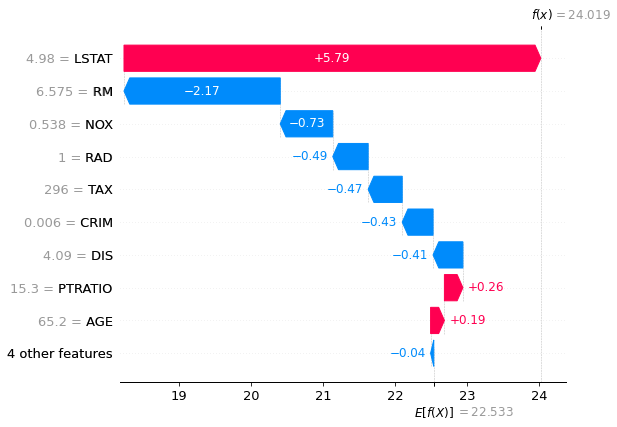

In [53]:
# train an XGBoost model
X, y = shap.datasets.boston()
model = xgb.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [18]:
X_train_2 = pd.DataFrame(X_test,columns=list(data_test.drop('SM',axis = 1)))
X_train_2

,ATI,DDI,EVI,MEI,NDMI,NDVI,NMDI,SIWSI,SRWI,SWCI,TVDI,VSDI,VSWI,TVCI,TWI
0,-0.002181,-0.105630,-0.084837,-0.054829,-0.470004,-0.271981,0.526010,0.626702,-0.008373,-0.896904,0.463012,-0.775927,-0.328858,0.463012,0.444918
1,-0.000879,-0.007173,0.132963,0.062293,0.155582,-0.271279,-0.938990,-0.416035,0.000267,0.983557,-0.021839,0.694983,0.065777,-0.021839,-1.261268
2,-0.000469,-0.293745,-0.128959,0.046375,-0.173820,-0.450484,-0.237781,0.328767,-0.004356,-0.302792,-0.946415,0.049424,-0.157239,-0.946415,-0.705318
3,0.001905,-0.461242,-0.056601,-0.039671,-0.784663,-0.045179,0.019524,0.782625,-0.012504,-0.645379,-0.037994,-0.504275,-0.230872,-0.037994,0.436147
4,0.000114,-0.087122,-0.292690,0.113139,-0.357225,-0.923948,0.731602,0.711606,-0.006859,-1.017896,-0.378538,-0.108672,-0.355339,-0.378538,-1.360517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800557,-0.002190,-0.003239,-0.287831,-0.065926,-0.028514,-0.890745,1.342152,0.661913,-0.002337,-1.283250,0.880851,-0.374853,-0.553807,0.880851,0.012193
1800558,-0.002475,0.334132,-0.363696,-0.047702,-0.695300,-1.111130,2.458656,1.407771,-0.011345,-1.646489,0.916942,-1.339896,-0.598871,0.916942,0.214791
1800559,0.006627,-0.390962,0.419964,-0.048101,1.023585,0.867219,-0.614792,-0.811573,0.013296,0.857979,0.421933,0.194172,0.124738,0.421933,0.568339
1800560,-0.002639,0.487758,-0.363001,-0.062135,-0.628248,-1.122536,2.283027,1.334997,-0.010468,-1.604827,1.389685,-1.391370,-0.610389,1.389685,0.438457


In [19]:
explainer = shap.TreeExplainer(model_bst)
shap_values = explainer(X_train_2)

[18:18:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/c_api/c_api.cc:943: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [49]:
shap_values = bst.predict(dtrain)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=list(data_test.drop('SM',axis = 1)))